# 데이터는 어떻게 할까?

일반적으로 Numpy 배열로 불러온다. 그 후 그 배열을 torch.*Tensor로 변환함

# 이미지 분류기 학습하기
1. torchvision을 사용해 CIFAR10의 train/test 데이터셋 불러오고, 정규화한다.
2. 합성곱 신경망을 정의한다.
3. 손실 함수를 정의한다.
4. 학습용 데이터를 사용하여 신경망을 학습한다.
5. 시험용 데이터를 사용하여 신경망을 검사한다.

## 1. CIFAR10을 불러오기 정규화하기

In [2]:
# torchvision을 이용해 CIFAR10 불러오기
import torch
import torchvision
import torchvision.transforms as transforms

# torchvison의 데이터셋 출력은 [0,1] 범위, 이를 [-1, 1]의 범위로 정규화된 Tensor로 변환
transforms = transforms.Compose(
    [transforms.ToTensor(),  # 텐서 형태로 변환
    # Tensor 이미지의 픽셀 값을 정규화함. 첫 번째 튜플은 각 채널(R, G, B)의 평균, 두 번째 튜플은 각 채널의 표준편차
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]
)

batch_size = 4


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# 클래스 이름을 튜플 형태로 저장.
classes = ('plane','car','bird','cat','deer','dog','forg','horse','ship','truck')

Files already downloaded and verified


ship planeplanedog  


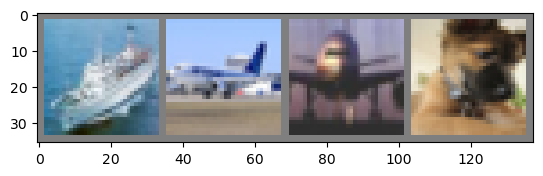

In [3]:
# 학습용 이미지 보기
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize ([-1,1]로 정규화하여 다시 [0,1] 범위로 만듦)
    npimg = img.numpy()     # Tensor를 numpy 배열로 변환
    plt.imshow(np.transpose(npimg, (1,2,0)))    # 차원 순서를 바꿈
    plt.show


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)    # 이더레이터로 만듦, 이더레이터는 next함수 호출할 때 마다 데이터를 하나씩 꺼내옴
images, labels = next(dataiter) # 배치 사이즈가 4이기 때문에 images에는 4개의 이미지 Tensor, labels에는 4개의 정답 label이 들어감

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images)) # 개별 이미지를 하나로 합쳐줌
# 정답출력
print(''.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


# 2. 합성곱 신경망 정의하기

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)         # 합성곱(convolution layer) (입력 채널 수, 출력 채널 수, 필터(커널) 크기)
        self.pool = nn.MaxPool2d(2, 2)          # 맥스 풀링(Max Pooling layer) (2x2크기의 window에서 가장 큰 값만 남겨 이미지의 크기를 절반으로 줄임, 특징 유지, 계산양 줄임)
        self.conv2 = nn.Conv2d(6, 16, 5)        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)   # 합성곱, 풀링을 거쳐서 Flatten해진 데이터를 입력으로 받는다. 16*5*5는 데이터 크기, 120은 노드 개수
        self.fc2 = nn.Linear(120, 84)           # 120개 노드 84개로 줄임
        self.fc3 = nn.Linear(84, 10)            # 84개 노드 10개로 줄임

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 다차원(채널, 높이, 너비)을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# 3. 손실 함수와 opimizer 정의하기

In [5]:
# 교차 엔트로피 손실(cross-entropy loss)과 모멘텀 값을 갖는 SGD를 사용한다.
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum= 0.9)

# 4. 신경망 학습하기

In [6]:
# 데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimizer)만 하면 된다.

for epoch in range(3): # 데이터 2번 반복

    running_loss=0.0
    for i, data in enumerate(trainloader, 0): # 미니배치 단위로 입력
        # data로부터 inputs, labels 받음
        input, labels = data

        # 변화도 매개변수를 0으로 초기화
        optimizer.zero_grad()

        # 순/역전파 + 최적화 진행
        outputs = net(input)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        running_loss += loss.item() #.item은 텐서에서 숫자 값만 가져오는 함수. 손실 값을 running_loss에 누적으로 저장
        if i % 2000 == 1999:        # 2000개의 미니배치 학습시킬 때마다 학습 상태 확인
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}') # 현재 에포크와 진행된 미니배치 개수, 2000개 배치의 평균 손실 값을 출력
            running_loss = 0.0      # 0으로 초기화

print('Finished Traning')

[1,  2000] loss: 2.157
[1,  4000] loss: 1.834
[1,  6000] loss: 1.693
[1,  8000] loss: 1.563
[1, 10000] loss: 1.496
[1, 12000] loss: 1.481
[2,  2000] loss: 1.399
[2,  4000] loss: 1.366
[2,  6000] loss: 1.324
[2,  8000] loss: 1.322
[2, 10000] loss: 1.315
[2, 12000] loss: 1.261
[3,  2000] loss: 1.214
[3,  4000] loss: 1.183
[3,  6000] loss: 1.202
[3,  8000] loss: 1.192
[3, 10000] loss: 1.167
[3, 12000] loss: 1.172
Finished Traning


In [7]:
# 학습한 모델 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 시험용 데이터로 신경망 검사하기
학습데이터 2회 반복해서 학습시킴

신경망이 예측한 출력과 진짜 정답을 비교하는 방식으로 확인, 예측이 맞으면 맞은 예측값 목록에 넣음

GroundTruth:  forg trucktruckdeer 


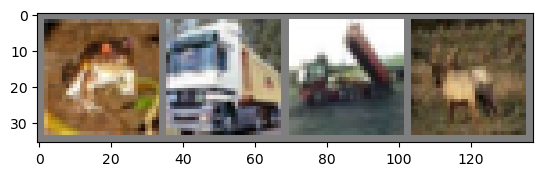

In [8]:
# 시험용 데이터 보기
dataiter = iter(testloader)
images, labels = next(dataiter)

# 이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ''.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
# 저장했던 모델 불러오기
net = Net()
net.load_state_dict(torch.load(PATH))

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36636\1928961872.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [10]:
# 출력은 10개 불류 각각에 대한 값으로 나타남. 더 높은 값이 나타나면 그 이미지가 해당 분류에 가깝다고 생각한 것.
# 신경망이 어떻게 예측했는지 보기
outputs=net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ''.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  forg truckbird deer 


In [11]:
# 전체 데이터셋에 대해서는 어떻게 동작?
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요 X
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images)

        # 예측값 추출
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [12]:
# 어떤 것들을 잘 분류하고, 어떤 것들을 못했는지 알아보기

# 각 분류에 대한 예측값을 위한 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs,1)
        # 각 분류별로 올바른 예측 수
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# 분류별 정확도
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 65.8 %
Accuracy for class: car   is 76.7 %
Accuracy for class: bird  is 54.7 %
Accuracy for class: cat   is 43.6 %
Accuracy for class: deer  is 50.7 %
Accuracy for class: dog   is 49.7 %
Accuracy for class: forg  is 78.2 %
Accuracy for class: horse is 68.7 %
Accuracy for class: ship  is 78.6 %
Accuracy for class: truck is 62.7 %


# GPU에서 학습하기
Tensor를 GPU로 이동했던 것 처럼, 신경망 또한 GPU로 옮길 수 있음

In [ ]:
# CUDA 장치를 사용하도록 설정합니다.
device = torch.devise('cuda:0' if torch.cuda.is_available() else 'cpu')

# CUDA 기기가 존재하면 아래 코드를 실행
print(device)

# 모든 모듈의 매개변수와 버퍼를 CUDA Tensor로 변경한다.
net.to(device)

# 각 단계에서 입력과 정답도 GPU에 보내야 한다.
inputs, labels = data[0].to(device), data[1].to(device)